In [ ]:
#imports
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import random

In [ ]:
#constants
data_path = '../dataset/trainingDataset.txt'
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 4000  # Number of samples to train on.
seed = 124

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
random.Random(seed).shuffle(lines)
for line in lines[: min(num_samples, len(lines))]:
    try:
      input_text, target_text = line.split(';')
    except:
      print(line)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
print(len(lines))
num_samples=len(lines)


3288


In [ ]:
# print(input_texts)
# print(target_texts)
# print(input_characters)
# print(target_characters)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print(input_characters)
print(target_characters)
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

[' ', ',', '.', '1', '2', 'E', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['\t', '\n', ' ', '(', ')', ',', '.', ':', '=', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of samples: 3288
Number of unique input tokens: 32
Number of unique output tokens: 36
Max sequence length for inputs: 24
Max sequence length for outputs: 41


In [ ]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])
print(input_token_index)
print(target_token_index)

{' ': 0, ',': 1, '.': 2, '1': 3, '2': 4, 'E': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}
{'\t': 0, '\n': 1, ' ': 2, '(': 3, ')': 4, ',': 5, '.': 6, ':': 7, '=': 8, '_': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}


In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
print('encoder_input_data',encoder_input_data.shape)
print('decoder_input_data',decoder_input_data.shape)
print('decoder_target_data',decoder_target_data.shape)

encoder_input_data (3288, 24, 32)
decoder_input_data (3288, 41, 36)
decoder_target_data (3288, 41, 36)


In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
print('encoder_input_data',encoder_input_data.shape)
print('decoder_input_data',decoder_input_data.shape)
print('decoder_target_data',decoder_target_data.shape)

encoder_input_data (3288, 24, 32)
decoder_input_data (3288, 41, 36)
decoder_target_data (3288, 41, 36)


In [ ]:
#Model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 32)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 36)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 295936      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  300032      input_2[0][0]                    
                                                                 lstm[0][1]            

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/200
42/42 [==============================] - 1s 29ms/step - loss: 2.3120 - accuracy: 0.3709 - val_loss: 1.8111 - val_accuracy: 0.5053
Epoch 2/200
42/42 [==============================] - 1s 13ms/step - loss: 1.7178 - accuracy: 0.4932 - val_loss: 1.4325 - val_accuracy: 0.5702
Epoch 3/200
42/42 [==============================] - 1s 13ms/step - loss: 1.2232 - accuracy: 0.6731 - val_loss: 1.1740 - val_accuracy: 0.6575
Epoch 4/200
42/42 [==============================] - 1s 13ms/step - loss: 0.7982 - accuracy: 0.8269 - val_loss: 0.5708 - val_accuracy: 0.8960
Epoch 5/200
42/42 [==============================] - 1s 13ms/step - loss: 0.4589 - accuracy: 0.9052 - val_loss: 0.5180 - val_accuracy: 0.8753
Epoch 6/200
42/42 [==============================] - 1s 13ms/step - loss: 0.3379 - accuracy: 0.9171 - val_loss: 0.2788 - val_accuracy: 0.9271
Epoch 7/200
42/42 [==============================] - 1s 14ms/step - loss: 0.2531 - accuracy: 0.9345 - val_loss: 0.2632 - val_accuracy: 0.9296
Epoch 

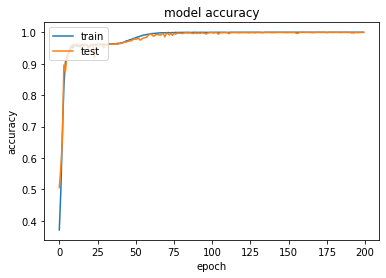

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

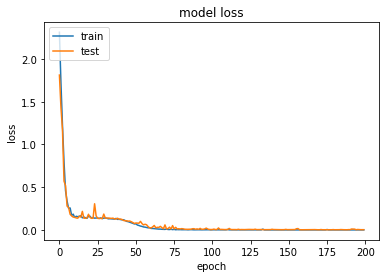

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# for seq_index in range(num_samples):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     #print(input_seq)
#     print(input_texts[seq_index]+' ==>', decoded_sentence)

In [ ]:
count=0
for seq_index in range(num_samples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    #print(input_seq)
    s = (target_texts[seq_index])
    s = s.strip()
    if(decoded_sentence.strip()!=s):  #target texts start with \t , but both target_texts and decoded sentences end with \n
      print(input_texts[seq_index]+' ==>', decoded_sentence)
      count+=1
print(count,'/',num_samples)

In [ ]:
#factor 100 => 376/830
#factor 400 epoch100 => 112/3288
#factor 400 epoch200 => 10/3288 ; 3/3288

Code for Testing

1.   Run all cells till cell 16
2.   continue from here

In [ ]:
test_path = '../testDataset2.txt'

In [ ]:
input_test_texts = []
with open(test_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for i in lines:
  if i=="" or i[0]=='#':
    continue
  input_test_texts.append(i)
input_test_texts
num_test_samples = len(input_test_texts)
print(input_test_texts)

['integers n, m and k', 'm lines', 'integers xi, yi and wi', 'next k lines', 'two integers ai and bi', 'integers n, m and k', 'next n lines', 'one integer n', 'one integer t', 't test cases follow', 'one integer n', 'n integers a1,a2,...,an', 'test case']


In [ ]:
encoder_input_test_data = np.zeros(
    (len(input_test_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
print('encoder_input_data',encoder_input_test_data.shape)

encoder_input_data (13, 24, 32)


In [ ]:
for i, input_text in enumerate(input_test_texts):
    #print('i:',i,'input_text',input_text)
    for t, char in enumerate(input_text):
        #print('t:',t,'char:',char)
        encoder_input_test_data[i, t, input_token_index[char]] = 1.
    encoder_input_test_data[i, t + 1:, input_token_index[' ']] = 1.
print('encoder_input_data',encoder_input_test_data.shape)

encoder_input_data (13, 24, 32)


In [ ]:
for seq_index in range(num_test_samples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_test_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    #print(input_seq)
    print(input_test_texts[seq_index]+' ==>', decoded_sentence)

integers n, m and k ==> n,k,m = list(map(int,input().split())))

m lines ==> for _ in range(m):

integers xi, yi and wi ==> x,i,w = list(map(int,input().split())))

next k lines ==> for _ in range(t)

two integers ai and bi ==> a,b = list(map(int,input().split())))

integers n, m and k ==> n,k,m = list(map(int,input().split())))

next n lines ==> for _ in range(n):

one integer n ==> n = (int)input()

one integer t ==> t = (int)input()

t test cases follow ==> f=int(input())

one integer n ==> n = (int)input()

n integers a1,a2,...,an ==> a=list(map(int,input().split()))

test case ==> for _ in range(t)

